You're a Data Analyst at WestCoast Realty Analytics, a real estate tech firm.
Your manager wants to build a system that estimates house prices in California based on property features like:

Median income of area

Number of rooms

Population

Proximity to ocean, etc.

These predictions will help investors and property buyers make better decisions

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

#Load dataset
data = fetch_california_housing()
df = pd.DataFrame(data.data, columns= data.feature_names)
df['Target'] = data.target

In [30]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   Target      20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [32]:
df.isnull().sum()

,0
MedInc,0
HouseAge,0
AveRooms,0
AveBedrms,0
Population,0
AveOccup,0
Latitude,0
Longitude,0
Target,0


In [33]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


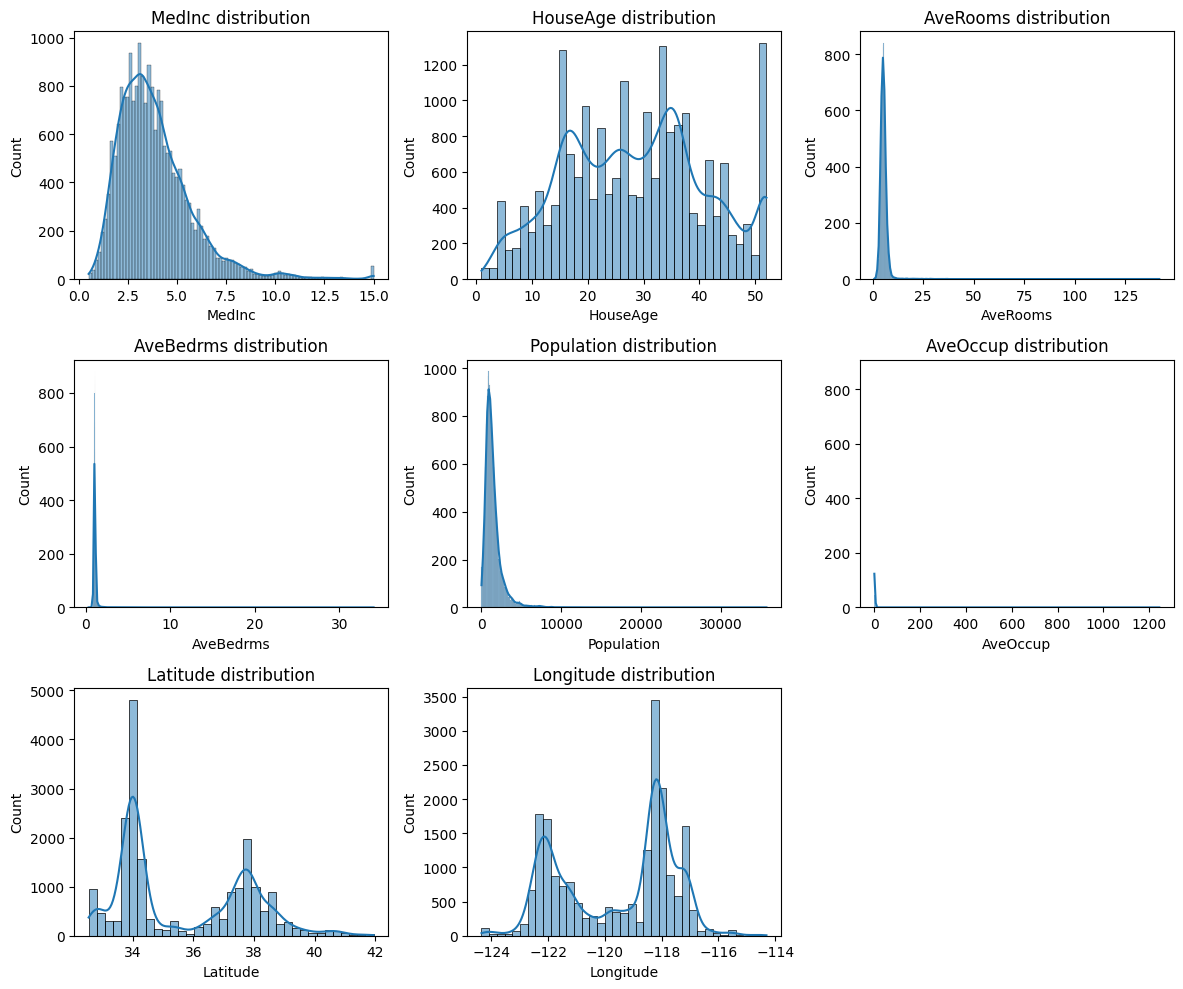

In [34]:
#check outliers in data
plt.figure(figsize=(12,10))
for i, col in enumerate(df.columns[:-1]):
  plt.subplot(3,3,i+1)
  sns.histplot(df[col], kde= True)
  plt.title(f"{col} distribution")
plt.tight_layout()
plt.show()

In [35]:
#Apply log1p (log(x+1)) to avoid log(0) error
df['MedInc_log'] = np.log1p(df['MedInc'])
df['Population_log'] = np.log1p(df['Population'])
df['AveRooms_log'] = np.log1p(df['AveRooms'])
df['AveBedrms_log'] = np.log1p(df['AveBedrms'])
df['AveOccup_log'] = np.log1p(df['AveOccup'])

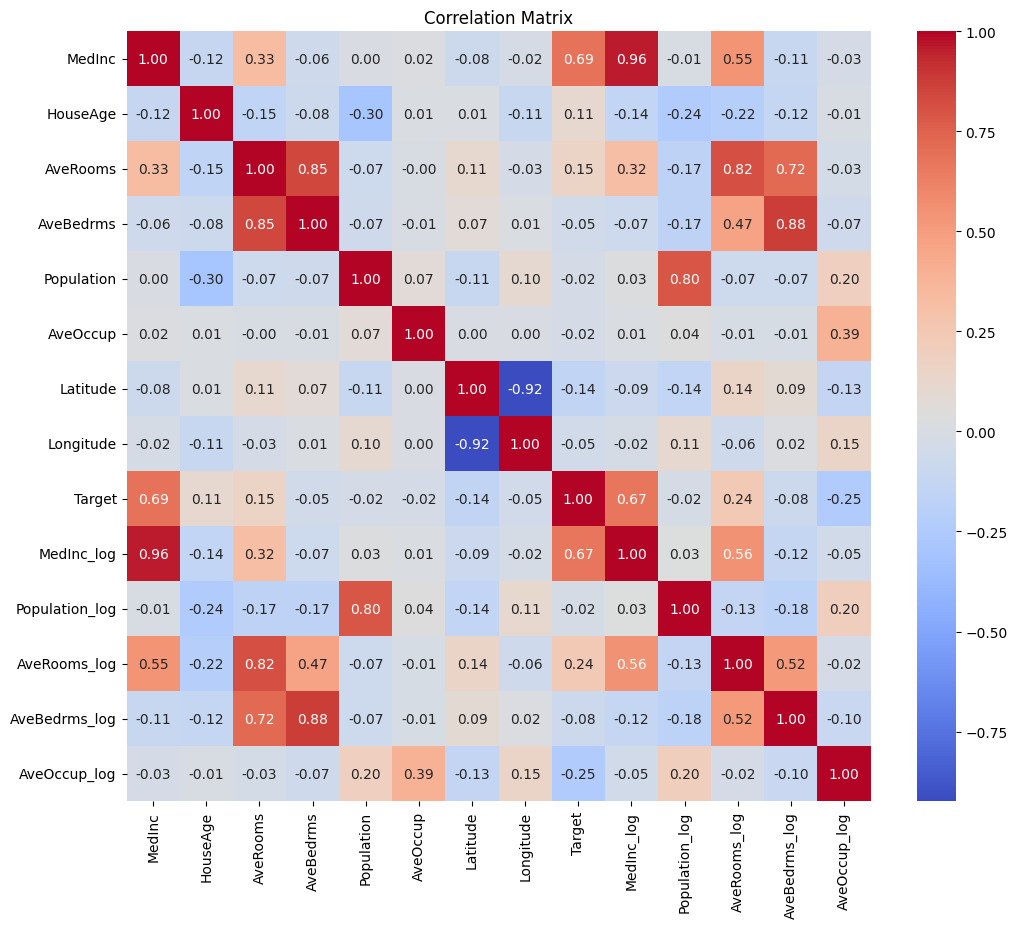

In [36]:
#correlation matrix
corr = df.corr(numeric_only = True)

#plot Heatmap
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, cmap = 'coolwarm', fmt = ".2f")
plt.title("Correlation Matrix")
plt.show()

In [37]:
#Correlation with Target
corr_target = corr["Target"].sort_values(ascending=True)
print(corr_target)

AveOccup_log     -0.247044
Latitude         -0.144160
AveBedrms_log    -0.079268
AveBedrms        -0.046701
Longitude        -0.045967
Population       -0.024650
AveOccup         -0.023737
Population_log   -0.021205
HouseAge          0.105623
AveRooms          0.151948
AveRooms_log      0.241034
MedInc_log        0.669914
MedInc            0.688075
Target            1.000000
Name: Target, dtype: float64


In [38]:
#define features and target
X = df[['MedInc_log', 'AveRooms_log', 'AveOccup_log', 'HouseAge', 'Latitude']]  #features
y = df['Target']

#train test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [39]:
#Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [40]:
model = LinearRegression()
model.fit(X_train_scaled,y_train)

LinearRegression()

In [41]:
y_pred = model.predict(X_test_scaled)

In [42]:
rmse = np.sqrt(mean_squared_error(y_test,y_pred))

In [43]:
r2 = r2_score(y_test,y_pred)

In [44]:
print("RMSE: ", rmse)
print("R2 Score: ", r2)

RMSE:  0.7703803628874982
R2 Score:  0.5470987200351967


In [45]:
# Combine feature names with coefficients
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', ascending=False)

print(coefficients)

        Feature  Coefficient
0    MedInc_log     0.867717
3      HouseAge     0.210412
4      Latitude    -0.106692
1  AveRooms_log    -0.147218
2  AveOccup_log    -0.260067


In [46]:
#applying ridge and lasso regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)

y_pred_ridge = ridge.predict(X_test_scaled)

ridge_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
ridge_r2 = r2_score(y_test, y_pred_ridge)

print("Ridge RMSE: ", ridge_rmse)
print("Ridge R2: ", ridge_r2)

Ridge RMSE:  0.7703790861641936
Ridge R2:  0.5471002211875302


In [47]:
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_scaled, y_train)

y_pred_lasso = lasso.predict(X_test_scaled)

lasso_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
lasso_r2 = r2_score(y_test, y_pred_lasso)

print("Lasso RMSE: ", lasso_rmse)
print("Lasso R2: ", lasso_r2)

Lasso RMSE:  0.8046544096163478
Lasso R2:  0.5059033250945832


In [48]:
pd.DataFrame({
    'Feature': X.columns,
    'Ridge Coef': ridge.coef_,
    'Lasso Coef': lasso.coef_
})

,Feature,Ridge Coef,Lasso Coef
0,MedInc_log,0.867632,0.683927
1,AveRooms_log,-0.147164,-0.000000
2,AveOccup_log,-0.260055,-0.155194
3,HouseAge,0.210399,0.116467
4,Latitude,-0.106698,-0.029556


In [49]:
#RandomForestRegressor

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_scaled,y_train)

y_pred_rf = rf.predict(X_test_scaled)

rf_rmse = np.sqrt(mean_squared_error(y_test,y_pred_rf))
rf_r2 = r2_score(y_test,y_pred_rf)

print("RandomForest RMSE: ", rf_rmse)
print("RandomForest R2: ", rf_r2)

RandomForest RMSE:  0.6079932048053773
RandomForest R2:  0.7179081162998887


In [50]:
#XGBOOST Model
xgb = XGBRegressor(random_state=42, objective='reg:squarederror')
xgb.fit(X_train_scaled,y_train)

y_pred_xgb= xgb.predict(X_test_scaled)

xgb_rmse = np.sqrt(mean_squared_error(y_test,y_pred_xgb))
xgb_r2 = r2_score(y_test,y_pred_xgb)
print("XGBOOST RMSE: ", xgb_rmse)
print("XGBOOST R2: ", xgb_r2)

XGBOOST RMSE:  0.5926617235965583
XGBOOST R2:  0.7319555005735991


In [51]:
#Hyperparameter Tuning
param_grid_xgb = {
    'n_estimators': [50,100,200],
    'max_depth':[3,5,7],
    'learning_rate': [0.01,0.05,0.1],
    'subsample': [0.8,1.0]
}

xgb = XGBRegressor(random_state=42, objective= 'reg:squarederror')

grid_xgb = GridSearchCV(xgb, param_grid_xgb,
                        cv=5,
                        scoring='neg_root_mean_squared_error',
                        n_jobs=-1,
                        verbose=1)
grid_xgb.fit(X_train_scaled,y_train)
print("Best XGBOOST Parameters: ", grid_xgb.best_params_)
print("Best CV RMSE: ", -grid_xgb.best_score_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best XGBOOST Parameters:  {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Best CV RMSE:  0.5787635274514273


## SHAP - SHapely Additive exPlanation, exIt gives:

Global feature importance (which features matter most across the dataset)

Local explanation (why this particular prediction is high/low)

Directionality: Whether the feature pushed the prediction up or down

In [52]:
#pip install shap
import shap

#Create SHAP explainer
explainer= shap.Explainer(grid_xgb.best_estimator_)
shap_values = explainer(X_test_scaled)

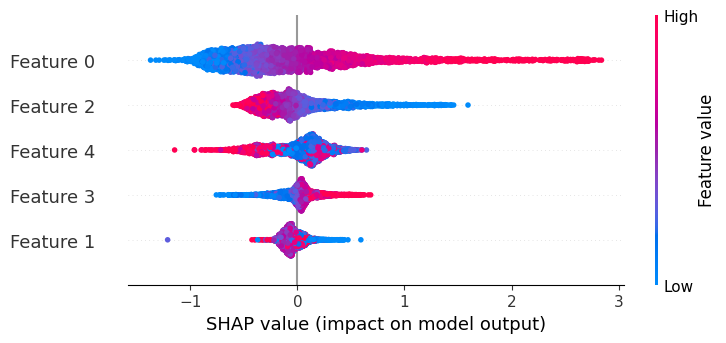

In [53]:
#Visualize all feature importance

shap.plots.beeswarm(shap_values)

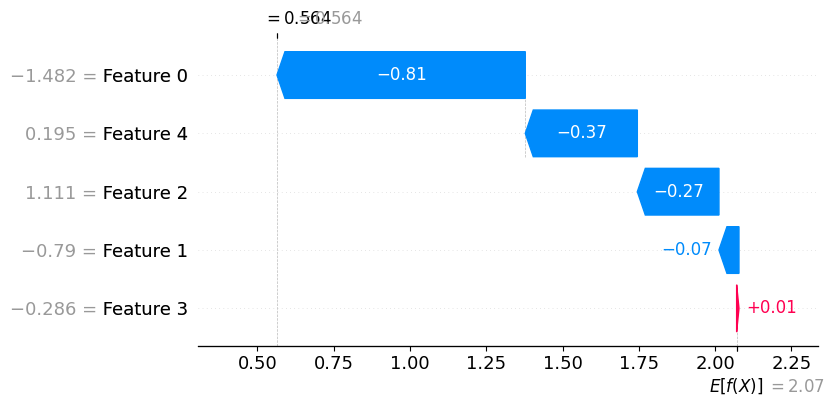

In [54]:
#Visulaize One Prediction
shap.plots.waterfall(shap_values[0])

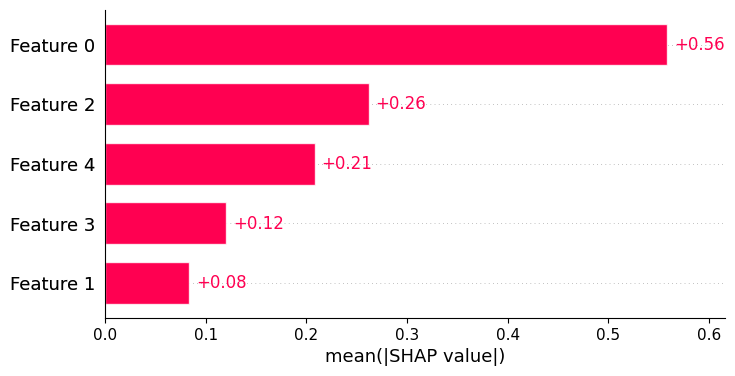

In [55]:
#Summary Bar Chart
shap.plots.bar(shap_values)

In [56]:
import joblib
joblib.dump(grid_xgb.best_estimator_, 'xgb_best_model.joblib')

['xgb_best_model.joblib']